In [1]:
import pandas as pd
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *

import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

ERROR 1: PROJ: proj_create_from_database: Open of /storage/homefs/hb22g102/mambaforge/envs/env11/share/proj failed


In [7]:
a = ["a", "d", "b", "c"]
a.sort()
a

['a', 'b', 'c', 'd']

In [8]:
exp_s = Experiment(
    "ERA5", "plev", "s", "6H", (1940, 2022), "JJA", -80, 30, 20, 80, [200, 250, 300], None, None, None, reduce_da=True
)
exp_T = Experiment(
    "ERA5", "surf", "t", "6H", (1940, 2022), "JJA", -30, 40, 30, 75, 250, 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None,
)
da_T = exp_T.da

[########################################] | 100% Completed | 48.55 s


In [9]:
net, centers, labels = exp_s.som_cluster(
    8,
    6,
    200,
    return_type=RAW_REALSPACE,
    force=False,
    train_kwargs=dict(train_algo="batch", epochs=100, start_learning_rate=0.05),
)

populations = net.compute_populations()
coords = net.neighborhoods.coordinates
centers_all_jets = find_jets(xr.Dataset({"s": centers}))
centers_props = compute_all_jet_props(centers_all_jets, centers)
centers_props_ds_uncat = props_to_ds(centers_props, centers.cluster)
centers_props_ds = categorize_ds_jets(centers_props_ds_uncat)
mask = labels_to_mask(labels)

100%|██████████| 48/48 [00:04<00:00,  9.96it/s]


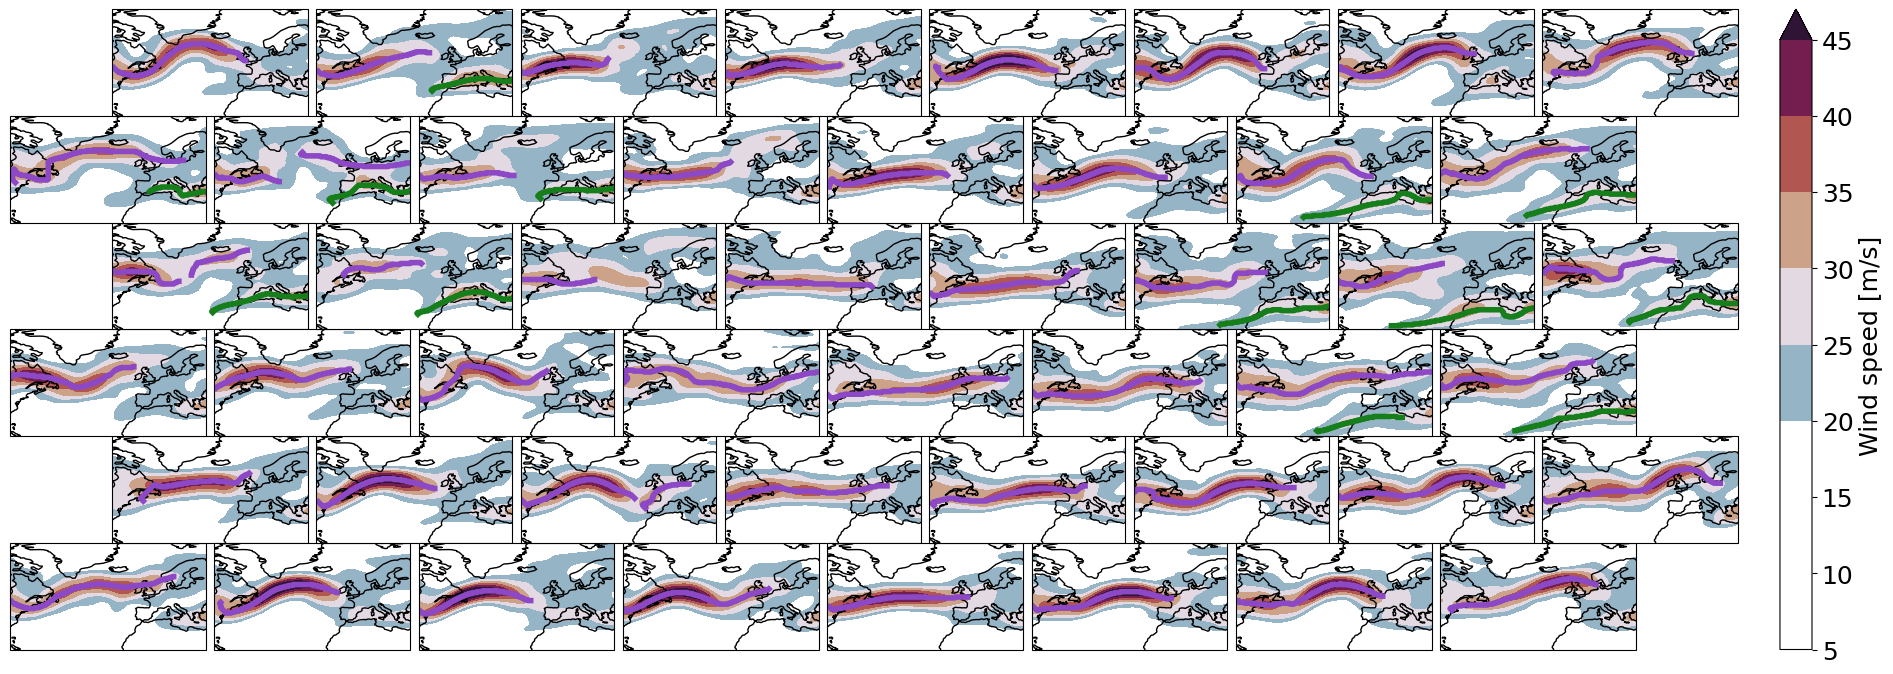

In [10]:
clu = Clusterplot(net.height, net.width, exp_s.region, honeycomb=True)
_ = clu.add_contourf(
    centers,
    cmap='twilight_shifted',
    transparify=3,
    nlevels=9,
    cbar_kwargs={"label": "Wind speed [m/s]", "pad": 0.02}
)
for jets, are_polar, ax in zip(centers_all_jets, centers_props_ds_uncat["is_polar"], clu.axes):
    for jet, is_polar in zip(jets, are_polar):
        color = COLORS5[int(is_polar)]
        ax.plot(*jet[["lon", "lat"]].to_numpy().T, lw=4, color=color)


100%|██████████| 48/48 [00:00<00:00, 53.29it/s]


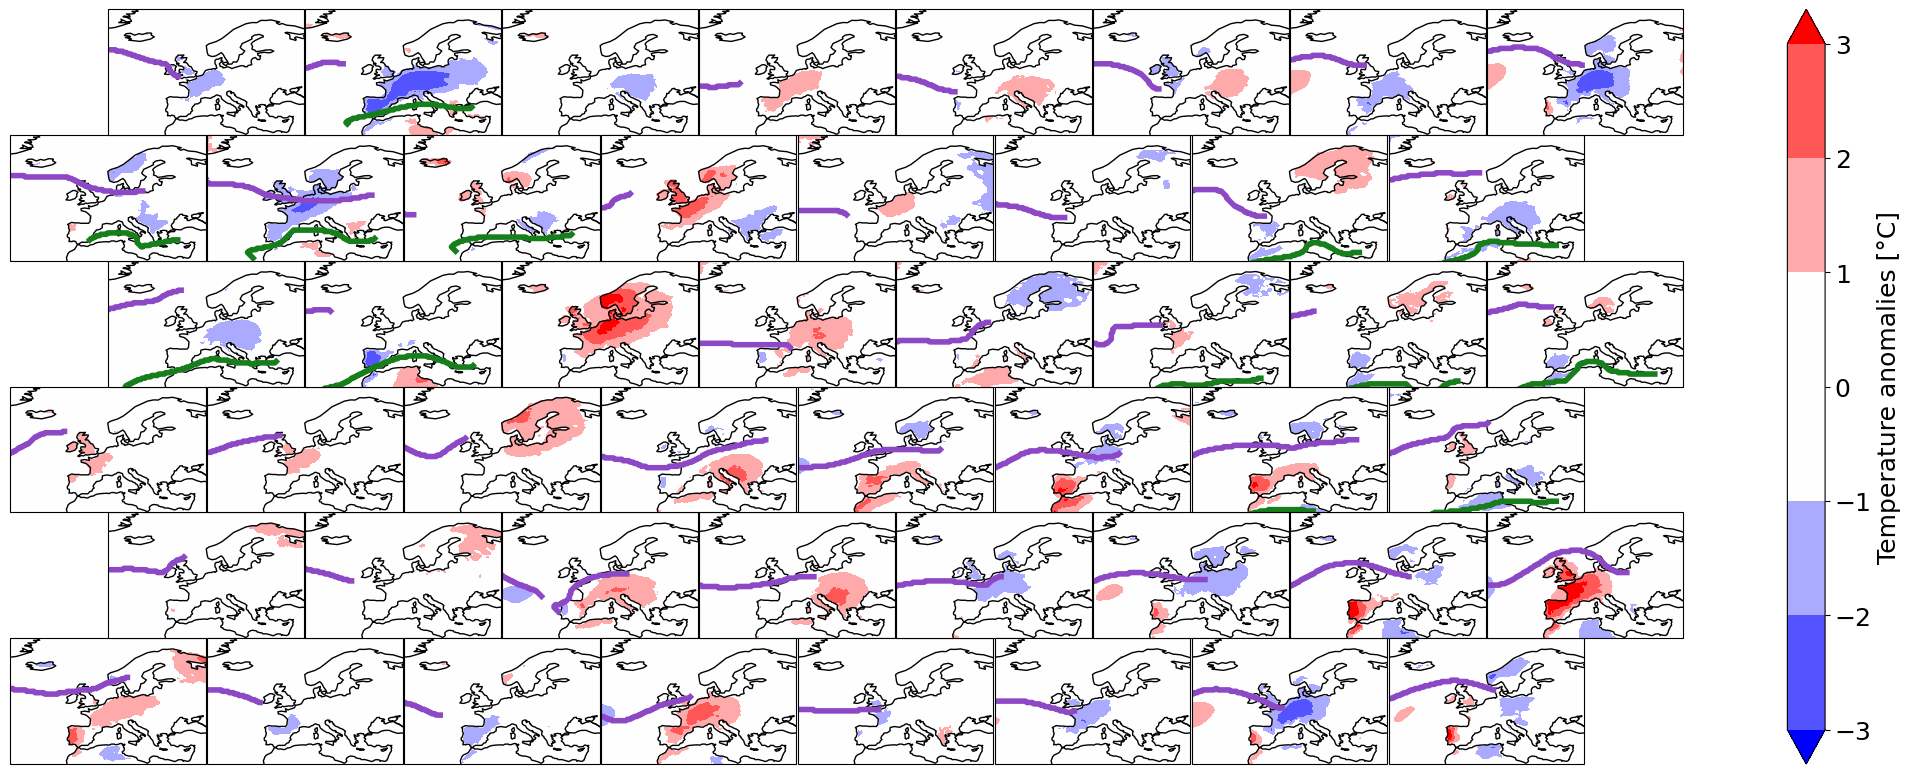

In [21]:
clu = Clusterplot(net.height, net.width, exp_T.region, honeycomb=True)
for ax in clu.axes:
    ax.autoscale(False)
clu.add_any_contour_from_mask(
    da_T, mask, "contourf", stippling=False, cbar_label="Temperature anomalies [°C]", cmap='bwr', q=0.999
)
for jets, are_polar, ax in zip(centers_all_jets, centers_props_ds_uncat["is_polar"], clu.axes):
    for jet, is_polar in zip(jets, are_polar):
        color = COLORS5[int(is_polar)]
        ax.plot(*jet[["lon", "lat"]].to_numpy().T, lw=4, color=color)
# plt.savefig(f'{FIGURES}/som_composites/SOM_temp.png')


In [24]:
da_pvs = Experiment("ERA5", "surf", "pvs", "6H", (1959, 2022), "JJA", *exp_s.region, 250, "hourofyear", {"hourofyear": ("win", 40)}).da
s_to_pvs = np.isin(labels.time.values, da_pvs.time.values)

100%|██████████| 48/48 [00:02<00:00, 20.30it/s]


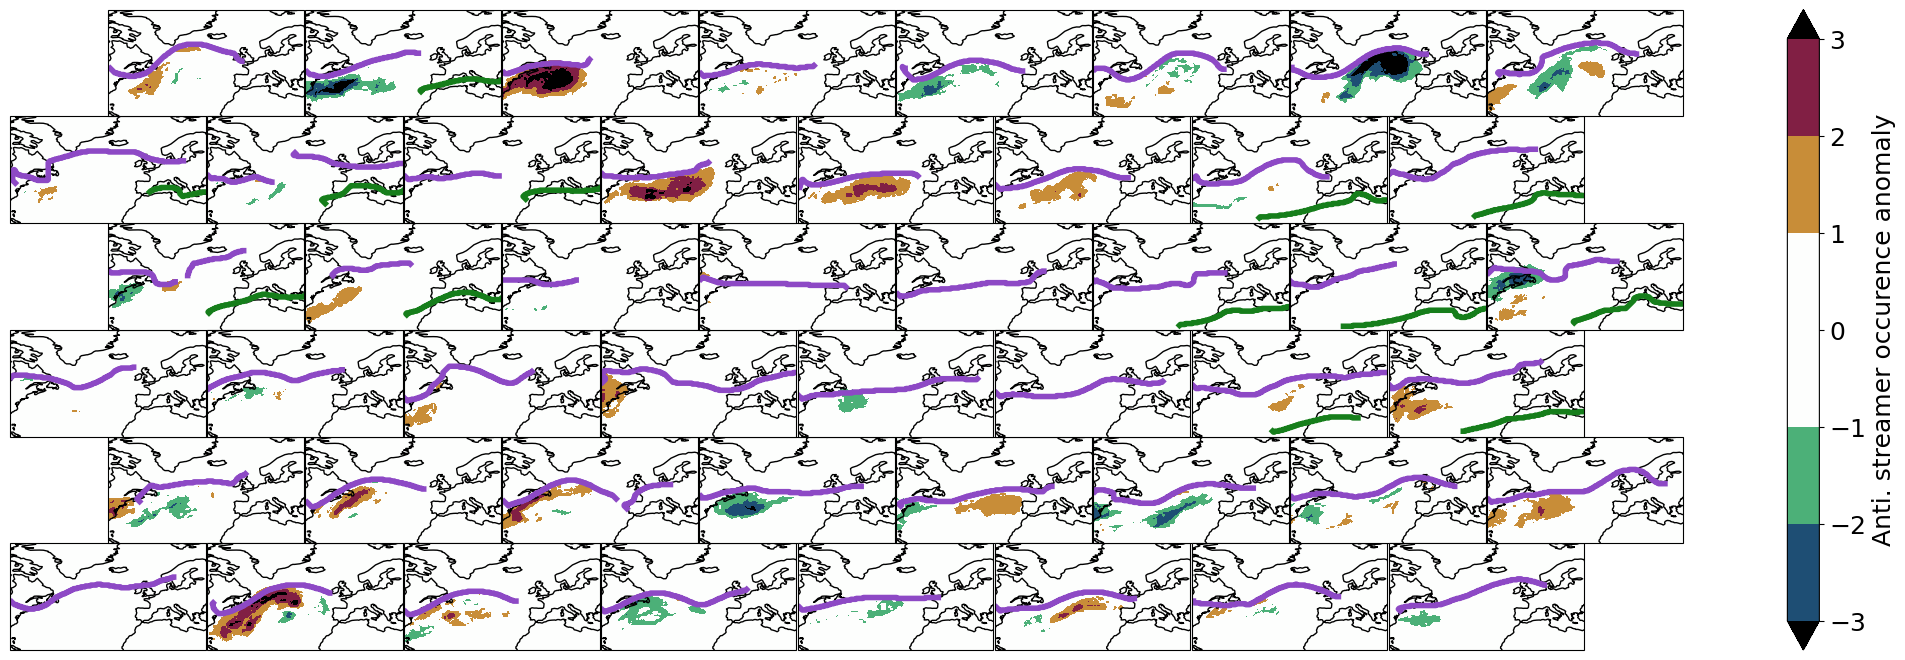

In [30]:
clu = Clusterplot(net.height, net.width, exp_s.region, honeycomb=True)
for ax in clu.axes:
    ax.autoscale(False)
clu.add_any_contour_from_mask(
    da_pvs.loc[:, 'anti'], mask[s_to_pvs], "contourf", stippling=False, cbar_label="Anti. streamer occurence anomaly", cmap=colormaps.seasons, q=0.998
)
for jets, are_polar, ax in zip(centers_all_jets, centers_props_ds_uncat["is_polar"], clu.axes):
    for jet, is_polar in zip(jets, are_polar):
        color = COLORS5[int(is_polar)]
        ax.plot(*jet[["lon", "lat"]].to_numpy().T, lw=4, color=color)

100%|██████████| 48/48 [00:02<00:00, 22.61it/s]


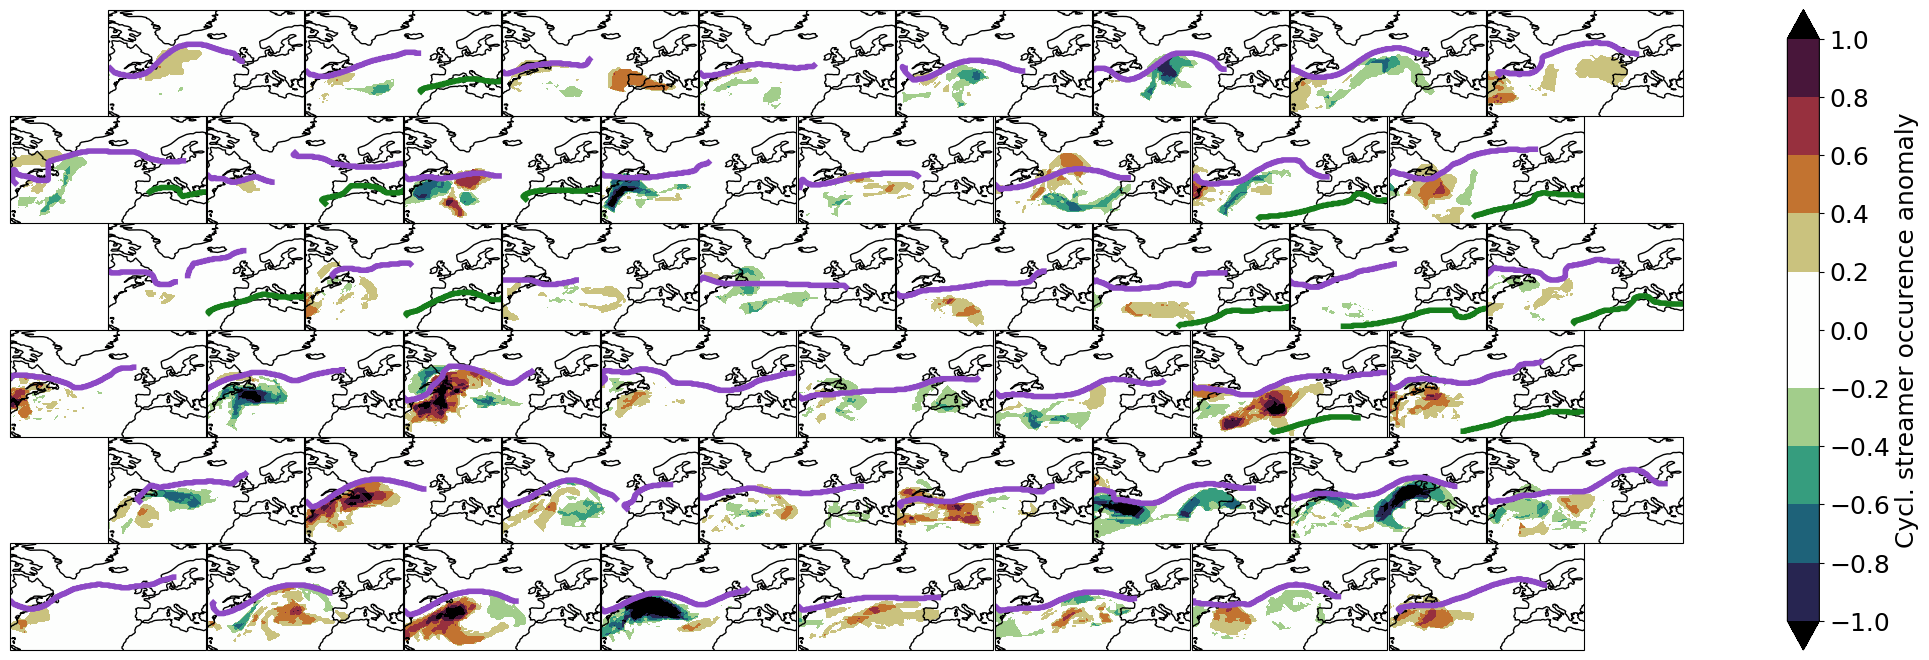

In [29]:
clu = Clusterplot(net.height, net.width, exp_s.region, honeycomb=True)
for ax in clu.axes:
    ax.autoscale(False)
clu.add_any_contour_from_mask(
    da_pvs.loc[:, 'cycl'], mask[s_to_pvs], "contourf", stippling=False, cbar_label="Cycl. streamer occurence anomaly", cmap=colormaps.seasons, q=0.997
)
for jets, are_polar, ax in zip(centers_all_jets, centers_props_ds_uncat["is_polar"], clu.axes):
    for jet, is_polar in zip(jets, are_polar):
        color = COLORS5[int(is_polar)]
        ax.plot(*jet[["lon", "lat"]].to_numpy().T, lw=4, color=color)

100%|██████████| 36/36 [00:06<00:00,  5.57it/s]


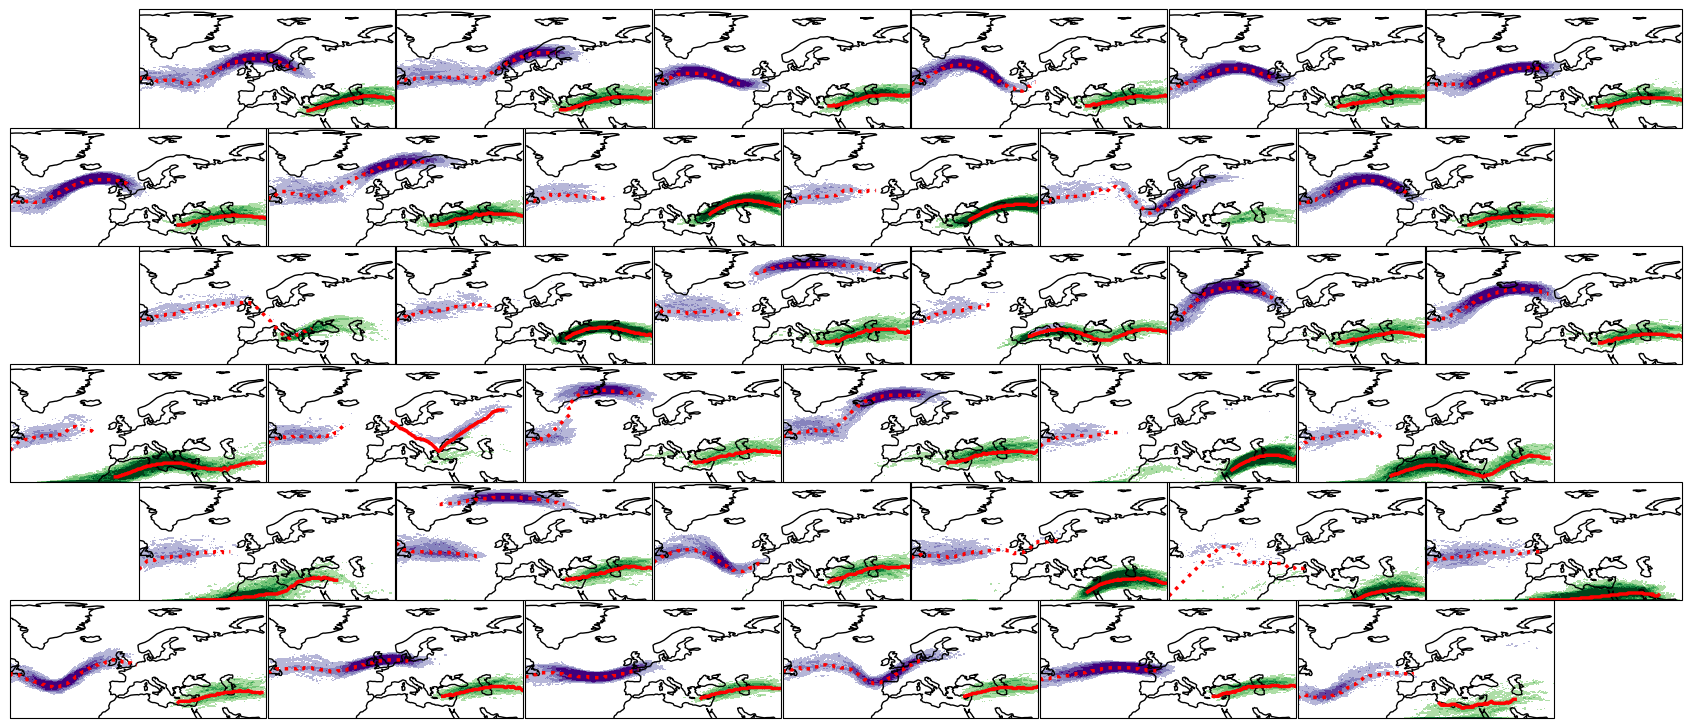

In [5]:
clu = Clusterplot(net.width, net.height, exp_T.region, honeycomb=True)
for ax in clu.axes:
    ax.autoscale(False)
_ = clu.add_any_contour_from_mask(
    da_jet_pos[:, 0] / da_jet_pos[:, 0].max(), mask, cbar_label="Subtropical jet occurence", transparify=2, cmap='Greens', draw_cbar=False,
)
_ = clu.add_any_contour_from_mask(
    da_jet_pos[:, 1] / da_jet_pos[:, 1].max(), mask, cbar_label="Polar jet occurence", transparify=2, cmap='Purples', draw_cbar=False,
)
linestyles = ['solid', 'dotted']
is_polar = centers_props_ds['is_polar']
for ax, is_pol, jets in zip(clu.axes, is_polar.values, centers_all_jets):
    for j, (jet, is_p) in enumerate(zip(jets, is_pol)):
        x, y, s = jet.T
        ax.plot(x, y, color='red', ls=linestyles[int(is_p)], lw=2.5)

clu.fig.set_size_inches(*(clu.fig.get_size_inches() * np.array([0.8, 1])))
clu.fig.savefig(f'{FIGURES}/som_composites/SOM_jet_pos.png')